In [ ]:
!pip install shap
from google.colab import drive 
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#bringing in data
drive.mount('/content/gdrive')
df = pd.read_csv("gdrive/My Drive/clean_data_final.csv")
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,UID,Product.ID,Type,Air.temperature..K.,Process.temperature..K.,Rotational.speed..rpm.,Torque..Nm.,Tool.wear..min.,Machine.failure,Failure.type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,NONE
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,NONE
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,NONE
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,NONE
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,NONE


In [ ]:
#balance the dataset
df = df.drop(df[df['Machine.failure'] == 0].sample(frac=.96).index) #balancing the dataset
feature_names = df.columns[4:8]
print(feature_names)
df.head()

Index(['Process.temperature..K.', 'Rotational.speed..rpm.', 'Torque..Nm.',
       'Tool.wear..min.'],
      dtype='object')


,UID,Product.ID,Type,Air.temperature..K.,Process.temperature..K.,Rotational.speed..rpm.,Torque..Nm.,Tool.wear..min.,Machine.failure,Failure.type
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,NONE
33,34,L47213,L,298.9,309.3,1665,32.5,93,0,NONE
42,43,M14902,M,298.8,309.1,1368,49.1,117,0,NONE
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,PWF
69,70,L47249,L,298.9,309.0,1410,65.7,191,1,PWF


Variance:  4.439418973629475


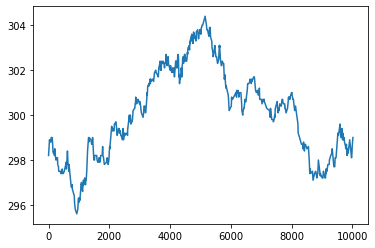

In [ ]:
plt.plot(df["Air.temperature..K."])
print("Variance: ", df["Air.temperature..K."].var())

In [ ]:
#checking balance
healthy_ct = 0
fail_ct = 0
for cell in df["Machine.failure"]:
    if cell == 0:
        healthy_ct += 1
    else:
        fail_ct += 1
print("Fail Ct: ", fail_ct)
print('Healthy Ct: ', healthy_ct)


pwf = 0
osf = 0
twf = 0
hdf = 0
none = 0
for cell in df["Failure.type"]:
    if cell == "PWF":
        pwf += 1
    elif cell == "OSF":
        osf += 1
    elif cell == "TWF":
        twf += 1
    elif cell == "HDF":
        hdf += 1
    else:
        none += 1
print()
print("TWF: ", twf)
print("PWF: ", pwf)
print("OSF: ", osf)
print("HDF: ", hdf)
print("None: ", none)

Fail Ct:  355
Healthy Ct:  386

TWF:  46
PWF:  95
OSF:  98
HDF:  115
None:  387


In [ ]:
#train test split time
from sklearn.model_selection import train_test_split
#TWF
X_features = df.iloc[:,4:8]
y = df[["Failure.type"]]

x_train, x_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.3)


Accuracy Score:  78.9237668161435 %


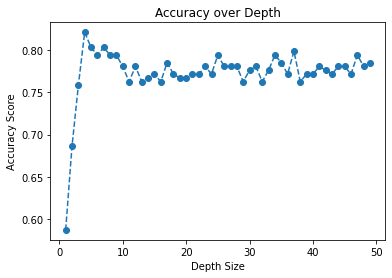

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import seaborn as sns

def get_best_depth(train_x,train_y,test_x,test_y):
    x,y = [], []
    for i in range(1,50):
        dtc = DecisionTreeClassifier(max_depth = i).fit(train_x, train_y)
        dtc_pred = dtc.predict(test_x)
        val = accuracy_score(dtc_pred, test_y)
        x.append(val)
        y.append(i)
        index_max = max(range(len(x)), key=x.__getitem__) + 1
    return x, y, index_max

store, indices, depth = get_best_depth(x_train, y_train,x_test, y_test)

plt.plot(indices, store, marker = 'o', linestyle = '--')
plt.title("Accuracy over Depth")
plt.ylabel("Accuracy Score")
plt.xlabel("Depth Size")



dtc_final = DecisionTreeClassifier().fit(x_train, y_train)
dtc_final_pred = dtc_final.predict(x_test)
print("Accuracy Score: ", accuracy_score(dtc_final_pred, y_test)*100, "%")

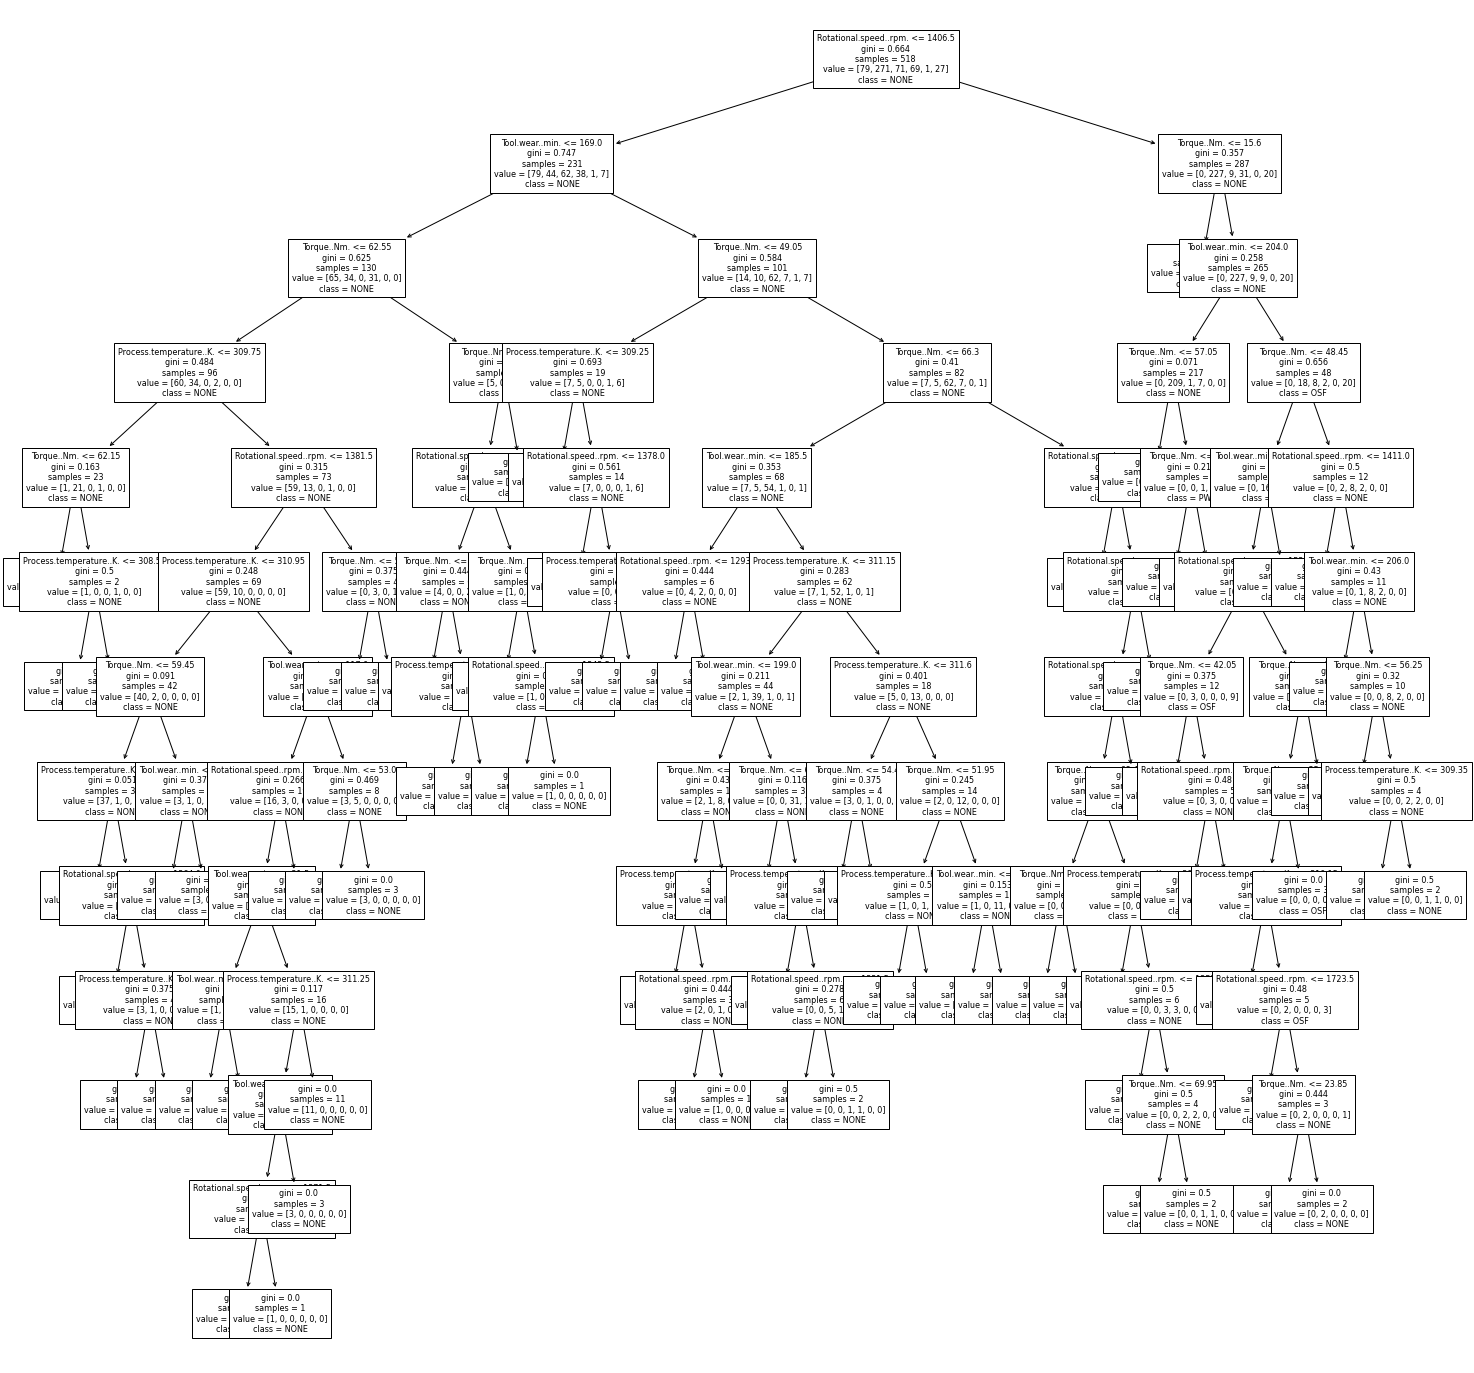

In [ ]:
plt.figure(figsize = (25,25))
plot_tree(dtc_final, class_names = list(df["Failure.type"]), feature_names = list(feature_names), fontsize = 8)
plt.savefig('tree.jpg',format='jpg')

In [ ]:
#built the whole tree but lets check for twf only
twf = df[(df["Failure.type"] == "TWF") | (df["Failure.type"] == "NONE")]
twf = twf.drop(twf[twf['Failure.type'] == "NONE"].sample(frac=.85).index)
y_twf = twf["Failure.type"]
x_twf = twf.iloc[:,4:8]


x_twf_train, x_twf_test, y_twf_train, y_twf_test = train_test_split(x_twf, y_twf, test_size = 0.3)

twf_store, twf_indices, twf_depth = get_best_depth(x_twf_train, y_twf_train,x_twf_test, y_twf_test)
# plt.plot(twf_indices, twf_store, marker = 'o', linestyle = '--')
# plt.title('Accuracy v Depth - TWF')
# plt.xlabel('Depth')
# plt.ylabel('Accuracy Score')
twf_clf = DecisionTreeClassifier().fit(x_twf_train, y_twf_train)

#model accuracy
twf_pred = twf_clf.predict(x_twf_test)
print("Accuracy Score: ", accuracy_score(twf_pred, y_twf_test) * 100, "%")
# none, t = 0, 0
# for cell in twf["Failure.type"]:
#     if cell == "NONE":
#         none += 1
#     else:
#         t += 1
# print(none, t)


Accuracy Score:  90.625 %


[Text(930.0, 1540.2, 'Tool.wear..min. <= 197.5\ngini = 0.49\nsamples = 72\nvalue = [41, 31]\nclass = TWF'),
 Text(744.0, 1359.0, 'gini = 0.0\nsamples = 35\nvalue = [35, 0]\nclass = TWF'),
 Text(1116.0, 1359.0, 'Rotational.speed..rpm. <= 1469.0\ngini = 0.272\nsamples = 37\nvalue = [6, 31]\nclass = NONE'),
 Text(930.0, 1177.8, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]\nclass = NONE'),
 Text(1302.0, 1177.8, 'Torque..Nm. <= 39.15\ngini = 0.355\nsamples = 26\nvalue = [6, 20]\nclass = NONE'),
 Text(1116.0, 996.6, 'Process.temperature..K. <= 310.1\ngini = 0.227\nsamples = 23\nvalue = [3, 20]\nclass = NONE'),
 Text(930.0, 815.4, 'Process.temperature..K. <= 309.9\ngini = 0.397\nsamples = 11\nvalue = [3, 8]\nclass = NONE'),
 Text(744.0, 634.2, 'Rotational.speed..rpm. <= 1829.5\ngini = 0.32\nsamples = 10\nvalue = [2, 8]\nclass = NONE'),
 Text(558.0, 453.0, 'Torque..Nm. <= 34.15\ngini = 0.444\nsamples = 6\nvalue = [2, 4]\nclass = NONE'),
 Text(372.0, 271.79999999999995, 'Rotational.speed..rpm. <=

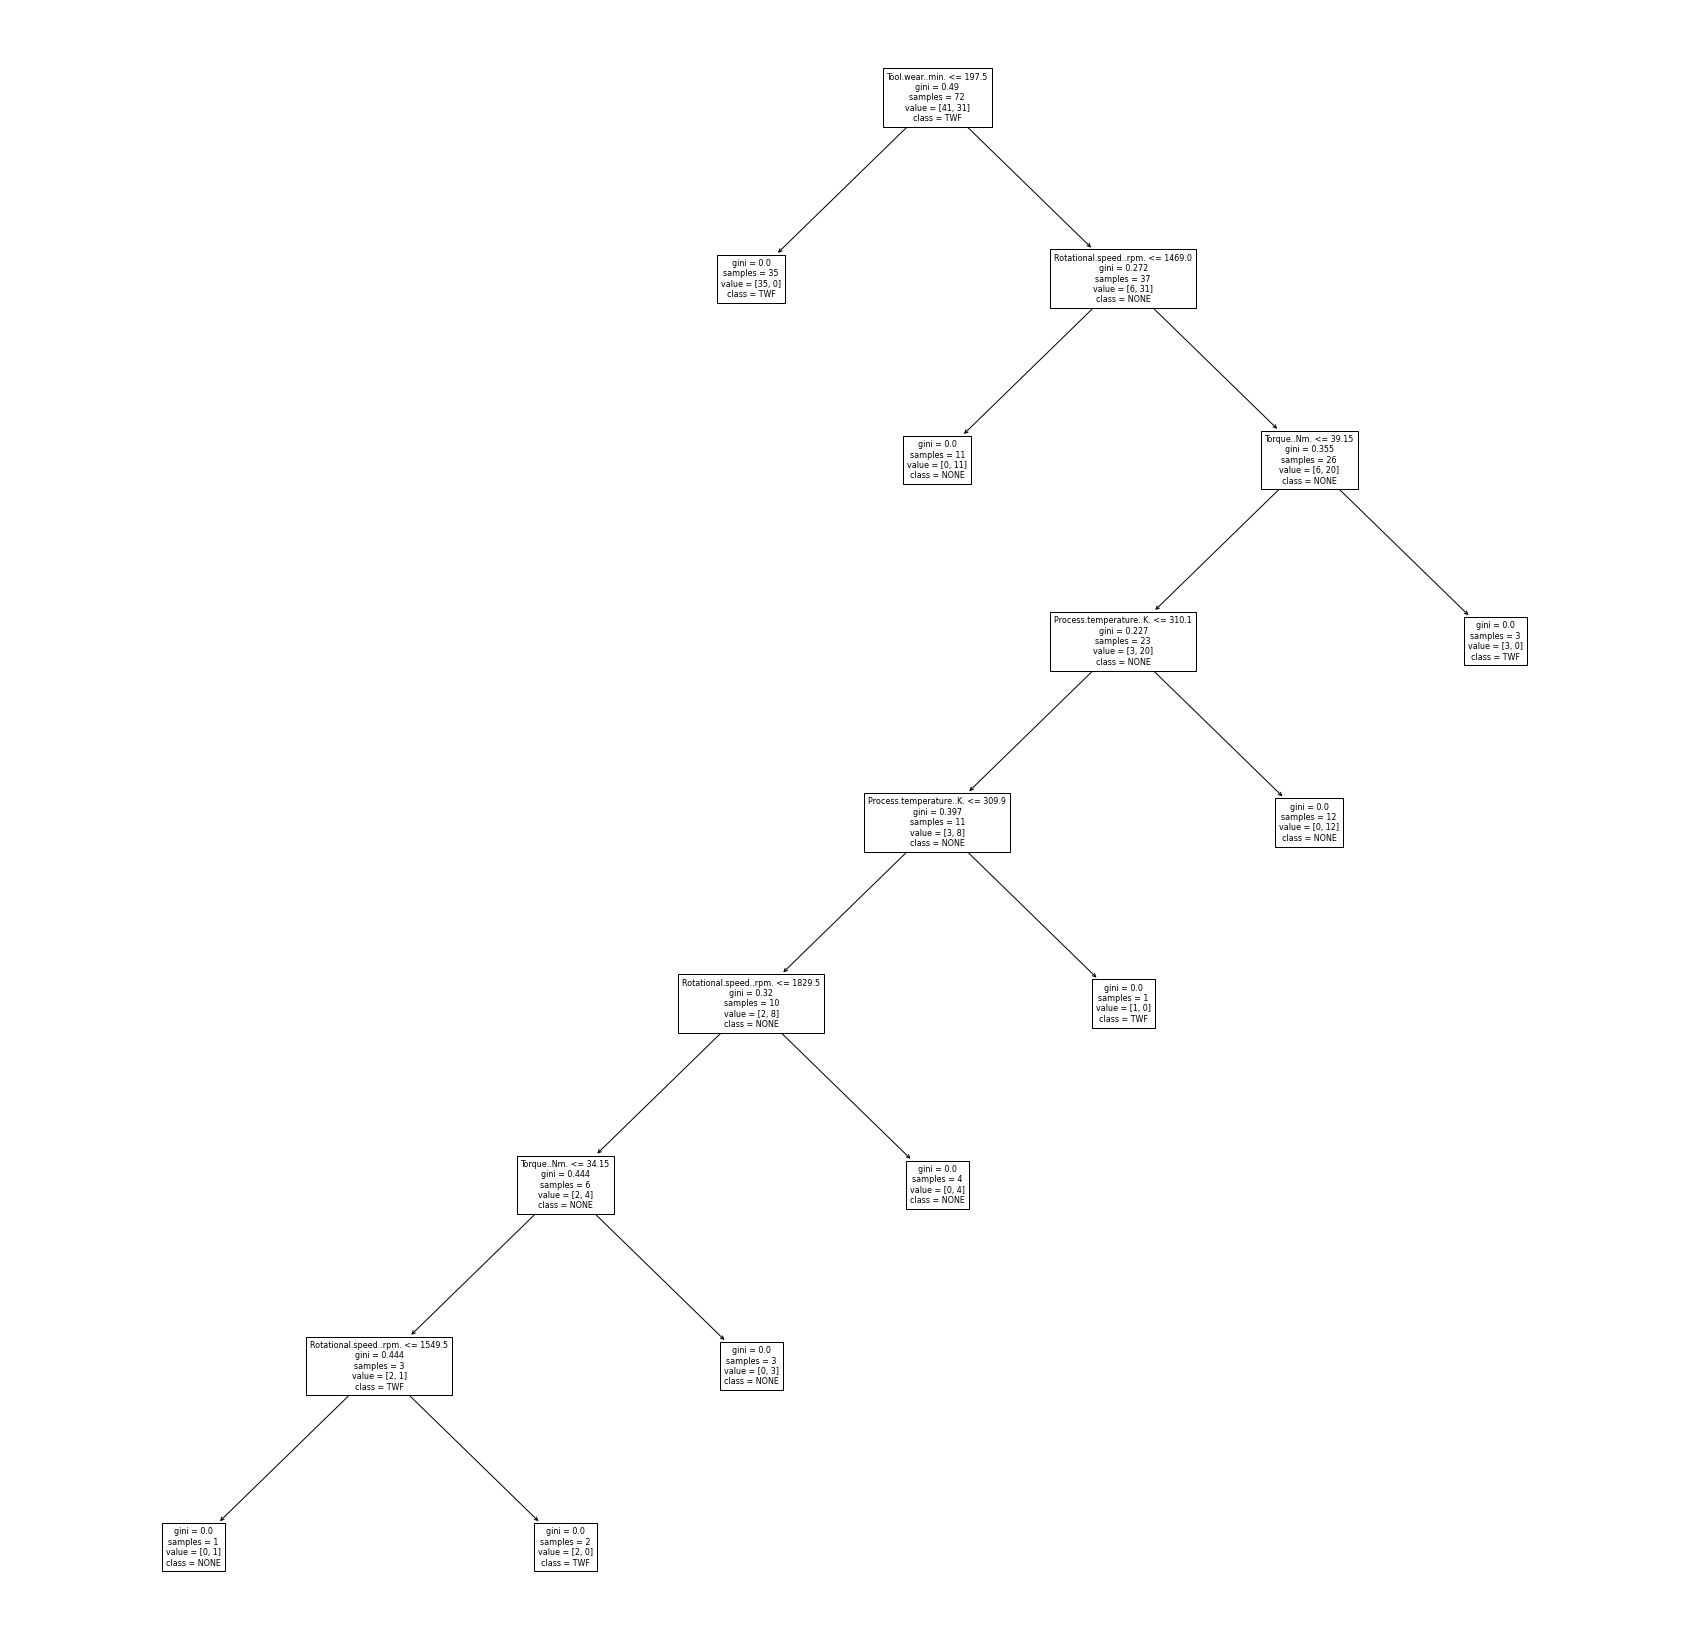

In [ ]:
plt.figure(figsize = (30,30))
plot_tree(twf_clf, class_names = list(y_twf), feature_names = list(feature_names), fontsize = 8)

In [ ]:
pwf = df[(df["Failure.type"] == "PWF") | (df["Failure.type"] == "NONE")]
pwf = pwf.drop(pwf[pwf['Failure.type'] == "NONE"].sample(frac=.75).index)
y_pwf = pwf["Failure.type"]
x_pwf = pwf.iloc[:,4:8]

x_pwf_train, x_pwf_test, y_pwf_train, y_pwf_test = train_test_split(x_pwf, y_pwf, test_size = 0.3)

pwf_store, pwf_indices, pwf_depth = get_best_depth(x_pwf_train, y_pwf_train, x_pwf_test, y_pwf_test)
# plt.plot(pwf_indices, pwf_store, marker = 'o', linestyle = '--')
# plt.title("Accuracy v Depth - PWF")
# plt.ylabel("Accuracy")
# plt.xlabel("Depth")

dtc_pwf = DecisionTreeClassifier(max_depth = pwf_depth).fit(x_pwf_train, y_pwf_train)
dtc_pwf_pred = dtc_pwf.predict(x_pwf_test)
print("Accuracy Score: ", accuracy_score(dtc_pwf_pred, y_pwf_test) * 100, "%")

# none, t = 0, 0
# for cell in pwf["Failure.type"]:
#     if cell == "NONE":
#         none += 1
#     else:
#         t += 1
# print(none, t)

Accuracy Score:  100.0 %


[Text(167.4, 181.2, 'Torque..Nm. <= 56.8\ngini = 0.5\nsamples = 133\nvalue = [68, 65]\nclass = NONE'),
 Text(83.7, 108.72, 'Rotational.speed..rpm. <= 2084.0\ngini = 0.334\nsamples = 85\nvalue = [67, 18]\nclass = NONE'),
 Text(41.85, 36.23999999999998, 'gini = 0.0\nsamples = 67\nvalue = [67, 0]\nclass = NONE'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 18\nvalue = [0, 18]\nclass = PWF'),
 Text(251.10000000000002, 108.72, 'Torque..Nm. <= 62.15\ngini = 0.041\nsamples = 48\nvalue = [1, 47]\nclass = PWF'),
 Text(209.25, 36.23999999999998, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = PWF'),
 Text(292.95, 36.23999999999998, 'gini = 0.0\nsamples = 42\nvalue = [0, 42]\nclass = PWF')]

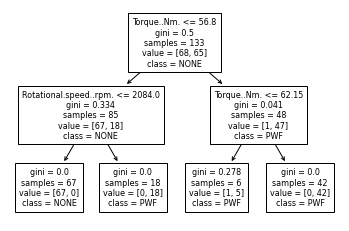

In [ ]:
plot_tree(dtc_pwf, class_names = list(dtc_pwf.classes_), feature_names = list(feature_names), fontsize = 8)

In [ ]:
osf = df[(df["Failure.type"] == "OSF") | (df["Failure.type"] == "NONE")]
osf = osf.drop(osf[osf['Failure.type'] == "NONE"].sample(frac=.7).index)
y_osf = osf["Failure.type"]
x_osf = osf.iloc[:,4:8]

x_osf_train, x_osf_test, y_osf_train, y_osf_test = train_test_split(x_osf, y_osf, test_size = 0.3)

osf_store, osf_indices, osf_depth = get_best_depth(x_osf_train, y_osf_train, x_osf_test, y_osf_test)
# plt.plot(osf_indices, osf_store, marker = 'o', linestyle = '--')
# plt.title("Accuracy v Depth - OSF")
# plt.ylabel("Accuracy")
# plt.xlabel("Depth")

dtc_osf = DecisionTreeClassifier().fit(x_osf_train, y_osf_train)
dtc_osf_pred = dtc_osf.predict(x_osf_test)
print("Accuracy Score: ", accuracy_score(dtc_osf_pred, y_osf_test) * 100, "%")
# none, t = 0, 0
# for cell in osf["Failure.type"]:
#     if cell == "NONE":
#         none += 1
#     else:
#         t += 1
# print(none, t)

Accuracy Score:  98.46153846153847 %


[Text(248.0, 1019.25, 'Tool.wear..min. <= 170.5\ngini = 0.499\nsamples = 149\nvalue = [77, 72]\nclass = OSF'),
 Text(124.0, 883.35, 'gini = 0.0\nsamples = 64\nvalue = [64, 0]\nclass = OSF'),
 Text(372.0, 883.35, 'Torque..Nm. <= 45.35\ngini = 0.259\nsamples = 85\nvalue = [13, 72]\nclass = NONE'),
 Text(248.0, 747.45, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = OSF'),
 Text(496.0, 747.45, 'Process.temperature..K. <= 307.25\ngini = 0.077\nsamples = 75\nvalue = [3, 72]\nclass = NONE'),
 Text(248.0, 611.55, 'Rotational.speed..rpm. <= 1377.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = OSF'),
 Text(124.0, 475.65, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = NONE'),
 Text(372.0, 475.65, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = OSF'),
 Text(744.0, 611.55, 'Process.temperature..K. <= 309.7\ngini = 0.053\nsamples = 73\nvalue = [2, 71]\nclass = NONE'),
 Text(620.0, 475.65, 'Process.temperature..K. <= 309.55\ngini = 0.172\nsamples = 21\nvalue = [2, 19]\nclass = NONE'),
 

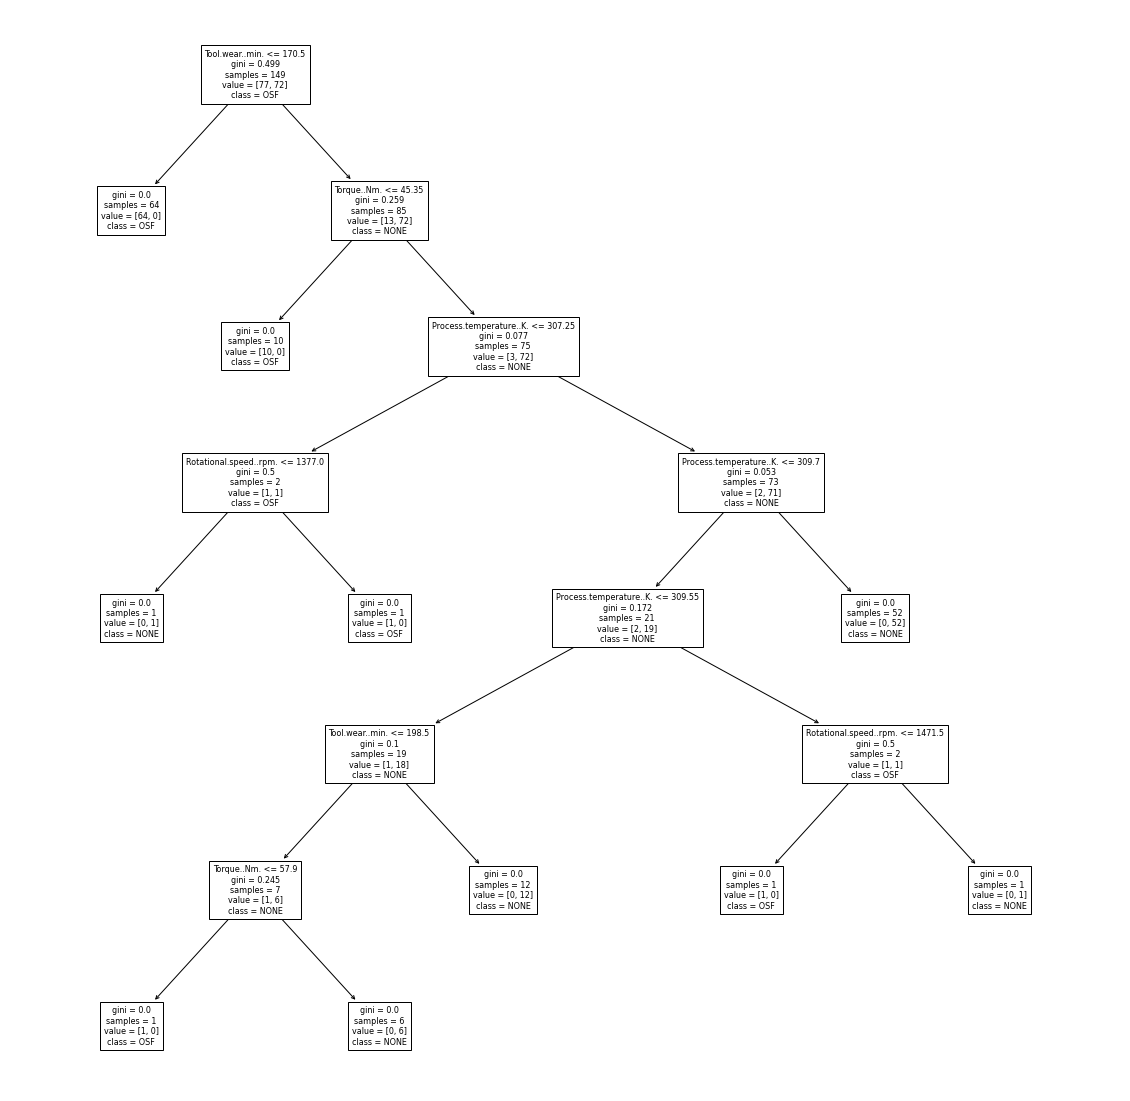

In [ ]:
plt.figure(figsize = (20,20))
plot_tree(dtc_osf, class_names = list(y_osf), feature_names = list(feature_names), fontsize = 8)

In [ ]:
hdf = df[(df["Failure.type"] == "HDF") | (df["Failure.type"] == "NONE")]
hdf = hdf.drop(hdf[hdf['Failure.type'] == "NONE"].sample(frac=.9).index)
y_hdf = hdf["Failure.type"]
x_hdf = hdf.iloc[:,4:8]

x_hdf_train, x_hdf_test, y_hdf_train, y_hdf_test = train_test_split(x_hdf, y_hdf, test_size = 0.3)

hdf_store, hdf_indices, hdf_depth = get_best_depth(x_hdf_train, y_hdf_train, x_hdf_test, y_hdf_test)
# plt.plot(hdf_indices, hdf_store, marker = 'o', linestyle = '--')
# plt.title("Accuracy v Depth - HDF")
# plt.ylabel("Accuracy")
# plt.xlabel("Depth")


dtc_hdf = DecisionTreeClassifier().fit(x_hdf_train, y_hdf_train)
dtc_hdf_pred = dtc_hdf.predict(x_hdf_test)
print("Accuracy Score: ", accuracy_score(dtc_hdf_pred, y_hdf_test) * 100, "%")


# none, t = 0, 0
# for cell in hdf["Failure.type"]:
#     if cell == "NONE":
#         none += 1
#     else:
#         t += 1
# print(none, t)


Accuracy Score:  97.87234042553192 %


[Text(558.0, 996.6, 'Rotational.speed..rpm. <= 1380.5\ngini = 0.404\nsamples = 107\nvalue = [77, 30]\nclass = NONE'),
 Text(372.0, 815.4000000000001, 'Process.temperature..K. <= 309.15\ngini = 0.094\nsamples = 81\nvalue = [77, 4]\nclass = NONE'),
 Text(186.0, 634.2, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = NONE'),
 Text(558.0, 634.2, 'Rotational.speed..rpm. <= 1365.5\ngini = 0.025\nsamples = 78\nvalue = [77, 1]\nclass = NONE'),
 Text(372.0, 453.0, 'gini = 0.0\nsamples = 62\nvalue = [62, 0]\nclass = NONE'),
 Text(744.0, 453.0, 'Rotational.speed..rpm. <= 1367.5\ngini = 0.117\nsamples = 16\nvalue = [15, 1]\nclass = NONE'),
 Text(558.0, 271.79999999999995, 'Tool.wear..min. <= 118.0\ngini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = NONE'),
 Text(372.0, 90.59999999999991, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = NONE'),
 Text(744.0, 90.59999999999991, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = NONE'),
 Text(930.0, 271.79999999999995, 'gini = 0.0\nsamples = 13\nvalu

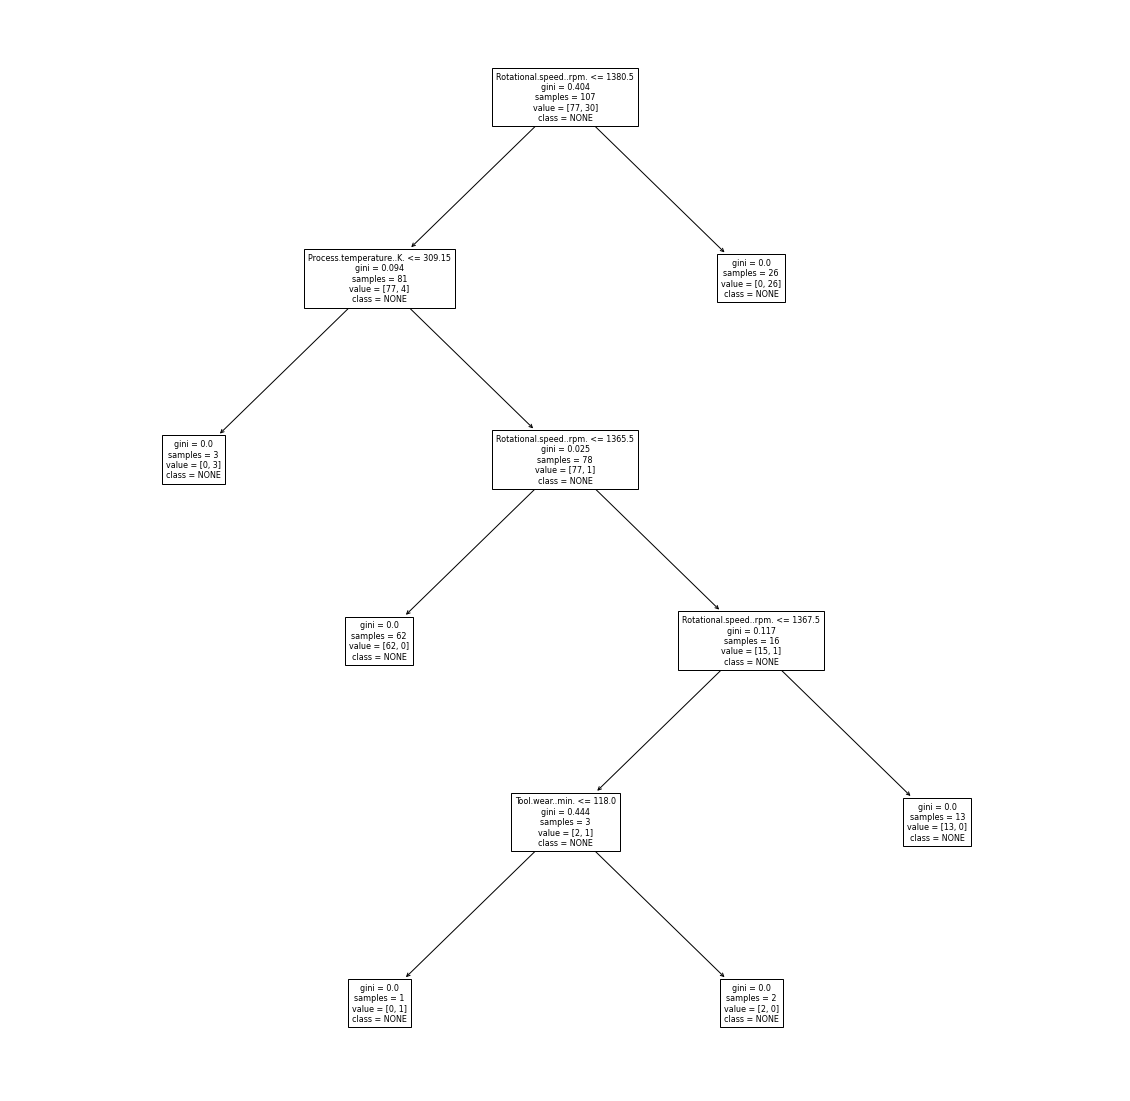

In [ ]:
plt.figure(figsize = (20,20))
plot_tree(dtc_hdf, class_names = list(y_hdf), feature_names = list(feature_names), fontsize = 8)

Text(0, 0.5, 'Fraction of Positives')

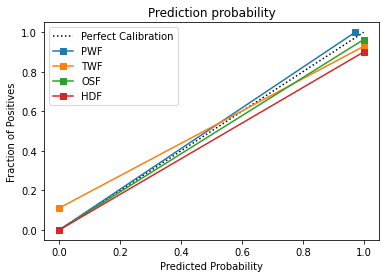

In [ ]:
from sklearn.calibration import calibration_curve

prob_pos_pwf = dtc_pwf.predict_proba(x_pwf_test)[:,1]
prob_pos_twf = twf_clf.predict_proba(x_twf_test)[:,1]
prob_pos_osf = dtc_osf.predict_proba(x_osf_test)[:,1]
prob_pos_hdf = dtc_hdf.predict_proba(x_hdf_test)[:,1]



frac_pos_pwf, mean_pred_pwf = calibration_curve(y_pwf_test, prob_pos_pwf)
frac_pos_twf, mean_pred_twf = calibration_curve(y_twf_test, prob_pos_twf)
frac_pos_osf, mean_pred_osf = calibration_curve(y_osf_test, prob_pos_osf)
frac_pos_hdf, mean_pred_hdf = calibration_curve(y_hdf_test, prob_pos_hdf)



plt.plot([0, 1], [0, 1], "k:", label = "Perfect Calibration")
plt.plot(mean_pred_pwf, frac_pos_pwf, "s-", label = "PWF")
plt.plot(mean_pred_twf, frac_pos_twf, "s-", label = "TWF")
plt.plot(mean_pred_osf, frac_pos_osf, "s-", label = "OSF")
plt.plot(mean_pred_hdf, frac_pos_hdf, "s-", label = "HDF")
plt.legend()
plt.title("Prediction probability")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

rand_forest_pure = RandomForestClassifier(n_estimators = depth).fit(x_train, y_train)
rand_forest_pure_pred = rand_forest_pure.predict(x_test)
print("RF Pure Acc: ", accuracy_score(rand_forest_pure_pred, y_test))


# Export as dot file
export_graphviz(dtc_final, out_file = 'tree.jpg', rounded = True, proportion = False, precision = 2, filled = True)




RF Pure Acc:  0.7982062780269058


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprec

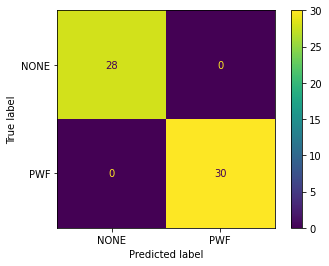

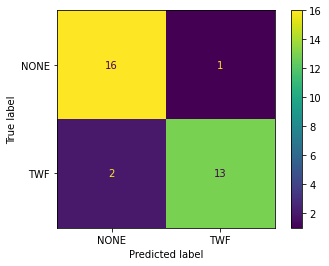

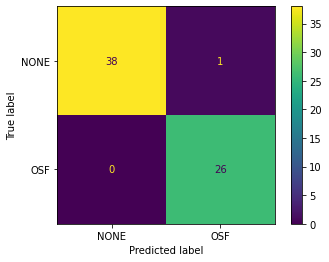

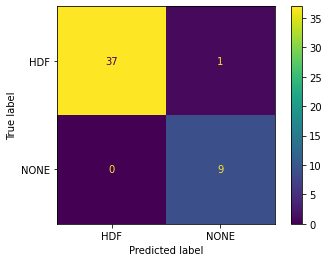

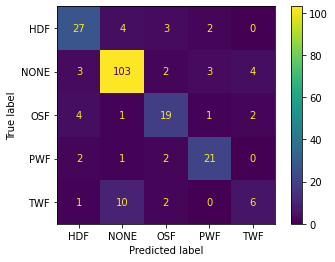

In [ ]:
conf_matrix_pwf = plot_confusion_matrix(dtc_pwf, x_pwf_test, y_pwf_test)
conf_matrix_twf = plot_confusion_matrix(twf_clf, x_twf_test, y_twf_test)
conf_matrix_osf = plot_confusion_matrix(dtc_osf, x_osf_test, y_osf_test)
conf_matrix_hdf = plot_confusion_matrix(dtc_hdf, x_hdf_test, y_hdf_test)
conf_matrix_pure = plot_confusion_matrix(dtc_final, x_test, y_test)

[Text(574.953125, 1037.7818181818182, 'Process Temp <= 1406.5\ngini = 0.499\nsamples = 518\nvalue = [270, 248]\nclass = Failed'),
 Text(320.65625, 938.9454545454546, 'Rotational Speed <= 53.1\ngini = 0.314\nsamples = 231\nvalue = [45, 186]\nclass = Healthy'),
 Text(133.6875, 840.1090909090909, 'Air Temp <= 309.8\ngini = 0.454\nsamples = 89\nvalue = [31, 58]\nclass = Healthy'),
 Text(46.5, 741.2727272727273, 'Torque <= 201.0\ngini = 0.444\nsamples = 24\nvalue = [16, 8]\nclass = Failed'),
 Text(31.0, 642.4363636363637, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]\nclass = Failed'),
 Text(62.0, 642.4363636363637, 'Process Temp <= 1399.5\ngini = 0.32\nsamples = 10\nvalue = [2, 8]\nclass = Healthy'),
 Text(46.5, 543.6, 'Torque <= 211.5\ngini = 0.198\nsamples = 9\nvalue = [1, 8]\nclass = Healthy'),
 Text(31.0, 444.76363636363635, 'Rotational Speed <= 47.55\ngini = 0.444\nsamples = 3\nvalue = [1, 2]\nclass = Healthy'),
 Text(15.5, 345.9272727272727, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\ncla

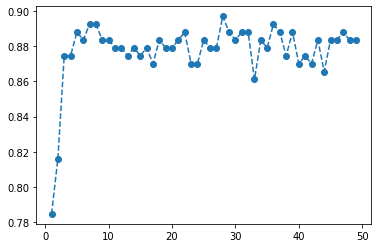

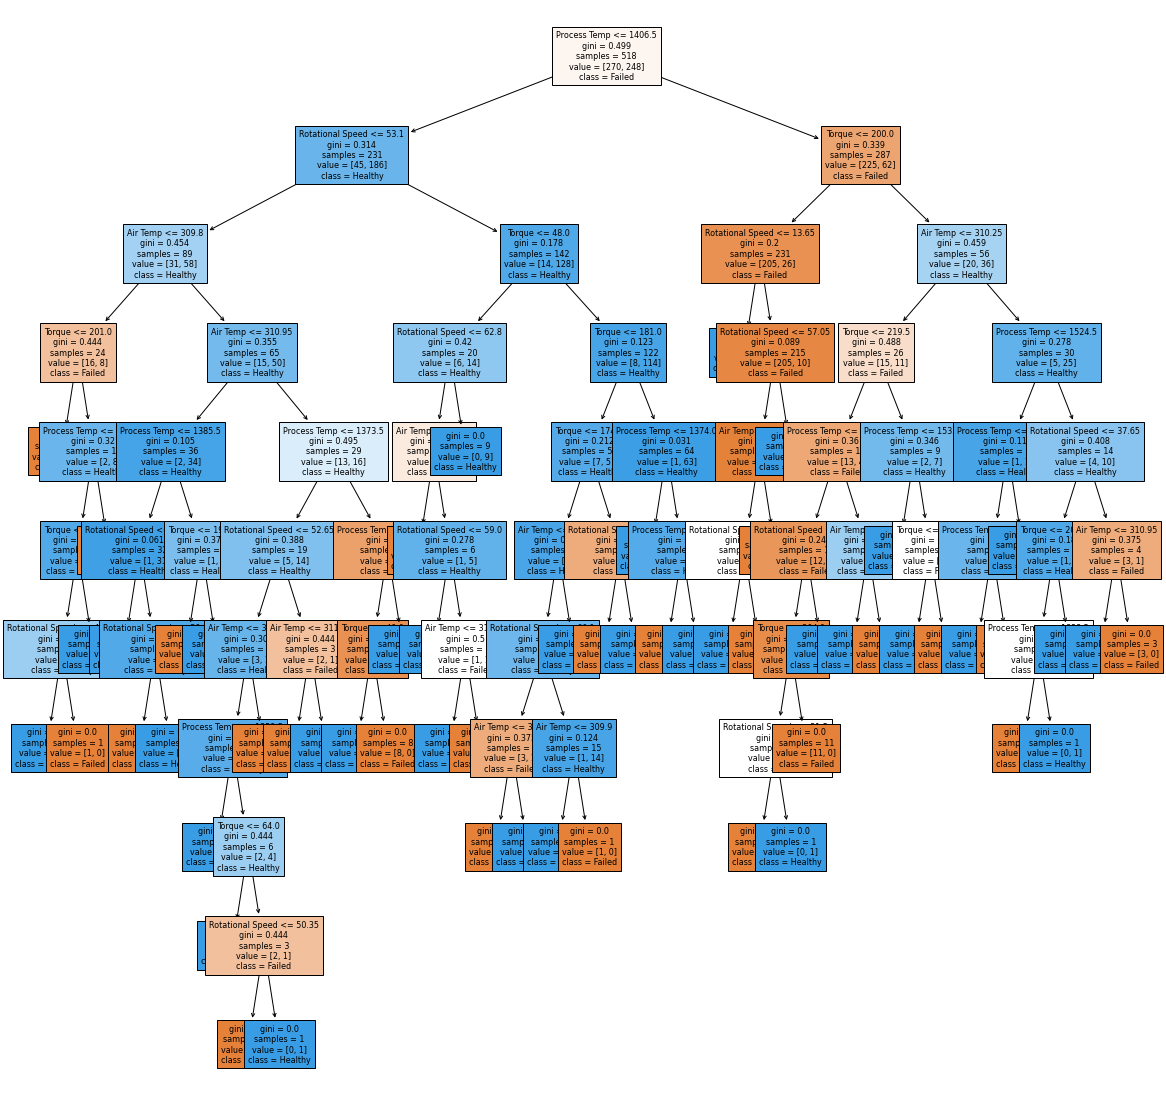

In [ ]:
#fail no fail model

y_plain = df[["Machine.failure"]]
x_plain = df.iloc[:,4:8]


x_plain_train, x_plain_test, y_plain_train, y_plain_test = train_test_split(x_plain, y_plain, test_size = 0.3)
plain_store, plain_indices, plain_depth = get_best_depth(x_plain_train, y_plain_train, x_plain_test, y_plain_test)
#acc v depth
plt.plot(plain_indices, plain_store, marker = 'o', linestyle = '--')


dtc_fnf = DecisionTreeClassifier(max_depth = plain_depth).fit(x_plain_train, y_plain_train)
plt.figure(figsize = (20,20))
plot_tree(dtc_fnf, class_names = ["Failed", "Healthy"],feature_names = list(["Air Temp","Process Temp", "Rotational Speed", "Torque", "Tool Wear"]) ,fontsize = 8, filled = True)



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Accuracy of FNF:  87.89237668161435 %


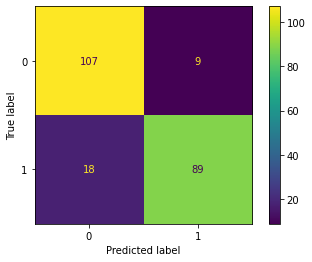

In [ ]:
plot_confusion_matrix(dtc_fnf, x_plain_test, y_plain_test)
dtc_fnf_pred = dtc_fnf.predict(x_plain_test)
print("Accuracy of FNF: ", accuracy_score(dtc_fnf_pred, y_plain_test) * 100 , "%")

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/107 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

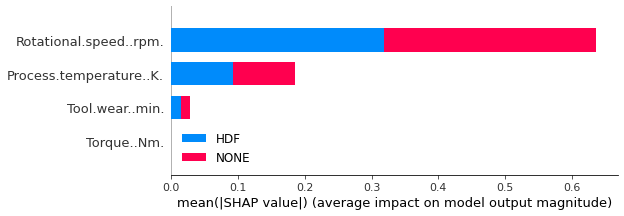

In [ ]:
explainer = shap.KernelExplainer(dtc_hdf.predict_proba, x_hdf_train)
shap_values = explainer.shap_values(x_hdf_train)
shap.summary_plot(shap_values, x_hdf_test, plot_type = 'bar', class_names = dtc_hdf.classes_)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Using 518 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/518 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

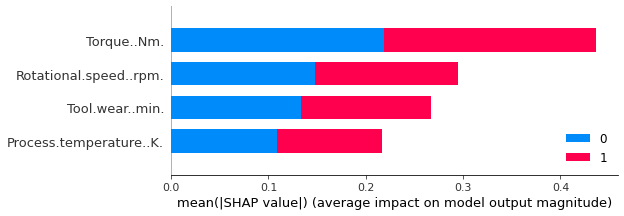

In [ ]:
explainer = shap.KernelExplainer(dtc_fnf.predict_proba, x_plain_train)
shap_values = explainer.shap_values(x_plain_train)
shap.summary_plot(shap_values, x_plain_test, plot_type = 'bar', class_names = dtc_fnf.classes_)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Using 518 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/518 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

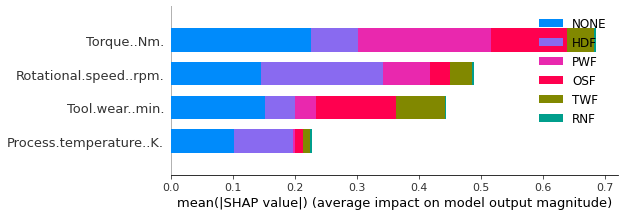

In [ ]:
explainer = shap.KernelExplainer(dtc_final.predict_proba, x_train)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_test, plot_type = 'bar', class_names = dtc_final.classes_)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Using 133 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/133 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

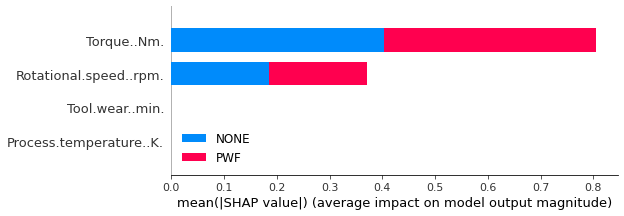

In [ ]:
explainer = shap.KernelExplainer(dtc_pwf.predict_proba, x_pwf_train)
shap_values = explainer.shap_values(x_pwf_train)
shap.summary_plot(shap_values, x_pwf_test, plot_type = 'bar', class_names = dtc_pwf.classes_)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Using 149 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/149 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

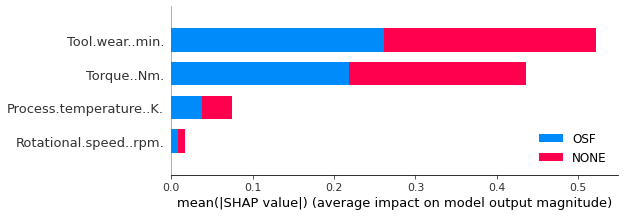

In [ ]:
explainer = shap.KernelExplainer(dtc_osf.predict_proba, x_osf_train)
shap_values = explainer.shap_values(x_osf_train)
shap.summary_plot(shap_values, x_osf_test, plot_type = 'bar', class_names = dtc_osf.classes_)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


  0%|          | 0/72 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

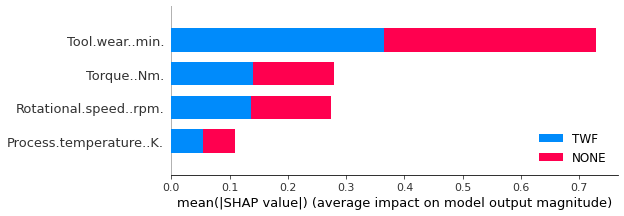

In [ ]:
explainer = shap.KernelExplainer(twf_clf.predict_proba, x_twf_train)
shap_values = explainer.shap_values(x_twf_train)
shap.summary_plot(shap_values, x_twf_test, plot_type = 'bar', class_names = twf_clf.classes_)

In [ ]:
explainer = shap.KernelExplainer(dtc_final.predict_proba, x_train)
shap_values = explainer.shap_values(x_train)
shap.plots.beeswarm(shap_values)


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Using 518 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/518 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

UnboundLocalError: ignored